filename: minianalysis__models_run_on_last_year_vs_next_year.py

description: 
    last updated: 6/13/2014
    Run model on last year of data used vs. next available year of data, as long as it is within a provided bound    
    
inputs:

outputs:

@author: Misha


In [1]:
from __future__ import division

import numpy as np

# setting the option below makes Pandas treat inf as NA. This is important when we calculate percent change, and divide a non-zero value by zero
import pandas as pd
pd.set_option('use_inf_as_na', True) 

import pickle
import sys
sys.path.append('../')    
import GSSUtility as GU # note, this imports the .PY file, so if I made changes to the IPYNB file, I first need to convert it 
                        # to PY for changes to actually take effect
                        # conversion can be done with 'jupyter nbconvert --to script GSSUtility.py'import numpy as np
from numpy import nan
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict

In [2]:
try: 
    %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
    reload(GU)
except:
    pass

In [47]:
#*********************************************************
allPropsForYearsUsed = []
allPropsForYearsPossible =[]
allParamSizesForYearsUsed = []
allParamSizesForYearsPossible = []
allRsForYearsUsed, allRsForYearsPossible = [], []

 
############################################################
if __name__ == "__main__":    

    try:
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=True, \
                                      centralIVs=False, nextYearBound=3, 
                                      linearModels=True)            
    print 'len of articleClasses:', len(articlesToUse)
#     raw_input('...')
    
    # define the storage containers for outputs
    group1 = 'on last GSS year'
    group2 = 'on first "future" GSS year'   
    groups = [group1, group2]
    outcomes = ['propSig_ControlVars', 'paramSizesNormed_ControlVars', 'Rs', 'adjRs',  
                'propSig_CentralVars', 'paramSizesNormed_CentralVars']

    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for outcome in outcomes:
        for group in groups:
            output[outcome][group] = []

    for article in articlesToUse:
#     log=open('log_file.txt', 'w')       
#     for article in random.sample(articlesToUse, 10):
#     for article in [a for a in articlesToUse if a.articleID == 1314]:
        print '\n===================\nProcessing article:', article.articleID
        
        RHS = article.IVs + article.controls
        
        for DV in article.DVs:
#             print DV, '~', RHS
            maxYearUsed = max(article.GSSYearsUsed)
            futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]
            nextYear = min(futureYearsPossible) # the arguments of GU.filterArticles function ensure that there is a suitable future year (within bound)
            
#             log.write('id'+str(article.articleID)+' year '+str(maxYearUsed))
            
            resOnDataUsed = GU.runModel(dataCont, maxYearUsed, DV, RHS); # models run on max year of data used
            if not resOnDataUsed: continue
            
#             log.write('id'+str(article.articleID)+' year '+str(nextYear))           
            resOnNextYear = GU.runModel(dataCont, nextYear, DV, RHS); # models run on min year of future data
            if not resOnNextYear: continue
            
            # Collapse all dummies for categorical variables into 1 variable
            # note, full variable names, e.g. C(race)=3, get renamed in the process
            resOnNextYear.pvalues = resOnNextYear.pvalues.groupby(lambda x: x.split('[')[0].split(',')[0]).mean()
            resOnNextYear.params = resOnNextYear.params.abs().groupby(lambda x: x.split('[')[0].split(',')[0]).mean()
            
            resOnDataUsed.pvalues = resOnDataUsed.pvalues.groupby(lambda x: x.split('[')[0].split(',')[0]).mean()
            resOnDataUsed.params = resOnDataUsed.params.abs().groupby(lambda x: x.split('[')[0].split(',')[0]).mean()
            
            # Checks on which results to record                
            if len(resOnDataUsed.params) != len(resOnNextYear.params):
                print 'The number of variables in original model is different from the number in model on future years. Skipping.'                    
                continue
            
            # the condition below means that i don't care about models in which orig var isn't stat. sig.
            results = [resOnDataUsed, resOnNextYear]
 
            # identify coefficients of CENTRAL and CONTROL variables
            centralVars = []            
            for civ in article.centralIVs:
                for param in results[0].params.index:
                    if civ in param: centralVars.append(param)
                        
            controlVars = set(results[0].params.index) - set(centralVars + ['Intercept'])
            
            # NOW "RECORD" THE OUTPUTS FROM THESE MODELS
            for i in range(2):    
                # output general model fit stuff
                output['Rs'][groups[i]].append(results[i].rsquared) 
                output['adjRs'][groups[i]].append(results[i].rsquared_adj) 
                
                # output CONTROL variable coefficients
                if len(controlVars)>0:         
                    output['propSig_ControlVars'][groups[i]].append(float(len([p for p in results[i].pvalues[controlVars] if p < 0.05])) \
                                                            /len(results[i].params[controlVars])) 
                    output['paramSizesNormed_ControlVars'][groups[i]].append(results[i].params[controlVars].mean())                
                else:
                    output['propSig_ControlVars'][groups[i]].append(np.nan)
                    output['paramSizesNormed_ControlVars'][groups[i]].append(np.nan)
                
                # output CENTRAL variable coefficients
                if len(centralVars)>0:
                    output['propSig_CentralVars'][groups[i]].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
                                                            /len(results[i].params[centralVars])) 
                    output['paramSizesNormed_CentralVars'][groups[i]].append(results[i].params[centralVars].mean())                
                else:
                    output['propSig_CentralVars'][groups[i]].append(np.nan)
                    output['paramSizesNormed_CentralVars'][groups[i]].append(np.nan)
                    
            output['metadata']['article_id'].append(article.articleID)                 
     
   
pickle.dump(output, open('output.pickle', 'w'))    
#     print 'TTests'
#     for outcome in outcomes:
#         print 'Means of group1 and group2:', np.mean(output[group1][outcome]), np.mean(output[group2][outcome]), 'Paired T-test of ' + outcome, ttest_rel(output[group1][outcome], output[group2][outcome])


len of articleClasses: 217

Processing article: 1314


Create dataframe that contains the output 
--

In [51]:
output = pickle.load(open('output.pickle'))
group1 = 'on last GSS year'
group2 = 'on first "future" GSS year'   
groups = [group1, group2]
outcomes = ['propSig_ControlVars', 'paramSizesNormed_ControlVars', 'Rs', 'adjRs', 
            'propSig_CentralVars', 'paramSizesNormed_CentralVars']

In [52]:
df_output = pd.DataFrame(index=np.arange(len(output['Rs'][group1])), 
                         columns=pd.MultiIndex.from_product([outcomes, groups]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[outcome, gp] = output[outcome][gp]
df_output['article_id'] = output['metadata']['article_id']
df_output.index = df_output['article_id']
df_output.head()

print 'Number of unique articles used:', len(df_output['article_id'].unique())

Number of unique articles used: 203


In [53]:
df_output.head()

outcome    propSig_ControlVars                             \
group         on last GSS year on first "future" GSS year   
article_id                                                  
2558                  0.000000                   0.200000   
4266                  0.333333                   0.333333   
4266                  0.000000                   0.000000   
4266                  1.000000                   1.000000   
6439                  0.800000                   0.400000   

outcome    paramSizesNormed_ControlVars                             \
group                  on last GSS year on first "future" GSS year   
article_id                                                           
2558                           0.112150                   0.146464   
4266                           0.043349                   0.023021   
4266                           0.006251                   0.014058   
4266                           0.224123                   0.206561   
6439                           0.178374                   0.141115   

outcome                  Rs                                       adjRs  \
group      on last GSS year on first "future" GSS year on last GSS year   
article_id                                                                
2558               0.039096                   0.022518         0.028324   
4266               0.010802                   0.002456         0.008949   
4266               0.000114                   0.000442        -0.001759   
4266               0.095805                   0.082393         0.094112   
6439               0.116589                   0.118300         0.105495   

outcome                               propSig_CentralVars  \
group      on first "future" GSS year    on last GSS year   
article_id                                                  
2558                         0.009571            0.250000   
4266                         0.001454            0.000000   
4266                        -0.000562            0.000000   
4266                         0.081471            1.000000   
6439                         0.105864            0.333333   

outcome                               paramSizesNormed_CentralVars  \
group      on first "future" GSS year             on last GSS year   
article_id                                                           
2558                         0.000000                     0.039369   
4266                         0.000000                     0.008024   
4266                         0.000000                     0.002613   
4266                         1.000000                     0.069327   
6439                         0.333333                     0.159017   

outcome                               article_id  
group      on first "future" GSS year             
article_id                                        
2558                         0.036225       2558  
4266                         0.010601       4266  
4266                         0.003513       4266  
4266                         0.070710       4266  
6439                         0.193837       6439

In [85]:
# output article IDs for use in replication project. 2016-06-07
fout = open('minianalysis_next_year_list_of_articles_used.csv',  'wb')
fout.write(','.join(map(str, sorted(df_output.article_id.unique())))) # unique article IDs used, separated by commas
fout.close()

In [86]:
# if using another, non-ipython notebook method of running the code
# load in the output of that other method, and set up the relevant variables
# df_output = pd.read_pickle('df_output.pickle')
# group1 = 'on last GSS year'
# group2 = 'on first "future" GSS year'   
# groups = [group1, group2]
# outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
#             'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

Plot the output
--

In [54]:
import matplotlib.pyplot as plt
import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)
%matplotlib inline

In [55]:
# %matplotlib inline

# outcomesToUse = df_output[group1].columns
# indices = np.arange(len(outcomesToUse))
# width = 0.35
# axes = plt.figure(figsize=(12,8)).add_subplot(111)
# error_config = {'ecolor': '0.3'}
# rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='r', 
#                  yerr=df_output[group1].std()/np.sqrt(len(df_output[group1])), error_kw=error_config) 
# rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='y', 
#                  yerr=df_output[group2].std()/np.sqrt(len(df_output[group2])), error_kw=error_config)

# # title, legend, etc
# plt.title('Models Using Last GSS Year vs. First "Future" Year', fontsize=18)
# plt.legend((rects1[0], rects2[0]), ('Last Yr.', '1st Future Yr.'), fontsize=15)
# plt.xlim((-1*width, len(outcomesToUse)))

# # tick labels
# # a = outcomesToUse
# a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
#      '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
# axes.set_xticks(indices+width)
# axes.set_xticklabels(a, rotation=90, fontsize=15)

# # label the bars with the difference between them
# diffs = (df_output[group1] - df_output[group2]).mean().values
# def autolabel(rects):
#     # attach some text labels
#     for i, rect in enumerate(rects):
#         height = rect.get_height()
#         if i!=7 and i!=4:
#             axes.text(rect.get_x()+width, 1.02*height, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
#         else: # this is for the p-value label, which has gone up
#             axes.text(rect.get_x()+width, 1.02*height+0.05, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
# autolabel(rects1)

# # savefig('../../Images/ASA2015/models_using_last_gss_year_vs_first_future_year.png', bbox_inches='tight')

In [78]:
# fig = plt.figure(figsize=(6,9))
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed_ControlVars',
                 u'propSig_ControlVars']

outcomeMap = {'propSig_ControlVars':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed_ControlVars':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}

# indices = [1,2,4,5,7,8]

# #############################################################################
# # CALCULATE DIFFERENCES WHERE EACH DV FROM EACH ARTICLE IS ITS OWN OBSERVATION, AND CLUSTERED SEs ON ARTICLE
# diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
# diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group2, outcome].mean(), df_output[group1, outcome].mean()) 
#                  for outcome in outcomesToUse]
# diffs = np.array(diffs)

# # naive SES
# # ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# # clustered SES
# clusteredSES = []
# article_ids = np.array(list(df_output.index)) 
# for outcome in outcomesToUse:
#     diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
#     mask = ~np.isnan(np.array(diff))
#     result_clustered = smf.ols(formula='y~x-1', \
#                      data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
#                                                                              cov_type='cluster', \
#                                                                     cov_kwds=dict(groups=article_ids[mask]))
#     clusteredSES.append(result_clustered.HC0_se[0])   
# clusteredSES = np.array(clusteredSES)

##############################################################################
# CALCULATE DIFFERENCES WHERE EACH *ARTICLE* IS *ONE* OBSERVATION (i.e. we'll average all observations at article level first),
# AND NO CLUSTERING OF SEs
from scipy.stats import ttest_rel

conservativeSES = []
diffs = []
diffs_strings = []

for outcome in outcomesToUse:
    print outcome
    group1outcome = df_output[outcome, group1].groupby(df_output.index).mean()
    group2outcome = df_output[outcome, group2].groupby(df_output.index).mean()

    # record absolute differences
    diff = (group2outcome - group1outcome)
    diffs.append(diff.mean())
    diffs_strings.append('(%0.3f - %0.3f)' % (group2outcome.mean(), group1outcome.mean()))
    se = diff.std() / np.sqrt(len(group1outcome))

    # record percent changes
#     perc_changes = 100*(group2outcome - group1outcome) / group1outcome
#     diffs.append(perc_changes.mean())
#     diffs_strings.append('(%0.3f - %0.3f)' % (group2outcome.mean(), group1outcome.mean()))
#     se = perc_changes.std() / np.sqrt(len(group1outcome))
    
    conservativeSES.append(se)
    
    # also do a t-test (related samples)
    mask = group1outcome.notnull() & group2outcome.notnull()
    print ttest_rel(group1outcome[mask], group2outcome[mask])
    
diffs = np.array(diffs)
conservativeSES = np.array(conservativeSES)

adjRs
Ttest_relResult(statistic=2.810200311560796, pvalue=0.005438078928868233)
Rs
Ttest_relResult(statistic=2.718347963941538, pvalue=0.007131370404180298)
paramSizesNormed_CentralVars
Ttest_relResult(statistic=2.2848767419777785, pvalue=0.023419042296379228)
propSig_CentralVars
Ttest_relResult(statistic=2.5426685198620014, pvalue=0.011794009553889262)
paramSizesNormed_ControlVars
Ttest_relResult(statistic=1.7051981877484306, pvalue=0.09032883473682664)
propSig_ControlVars
Ttest_relResult(statistic=0.6704576241596419, pvalue=0.5036474622368736)


0.426251888133641 0.38816154986493895 -3.0040410962296256


Text(0,0.5,'numerator (future year - last year)')

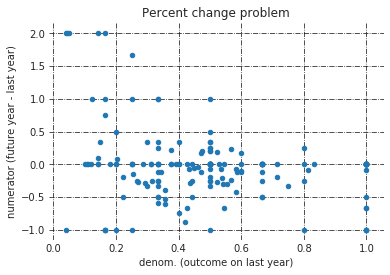

In [79]:
outcome = 'propSig_CentralVars'

group1outcome = df_output[outcome, group1].groupby(df_output.index).mean()
group2outcome = df_output[outcome, group2].groupby(df_output.index).mean()
    
perc_changes = 100*(group2outcome - group1outcome)/ group1outcome
print group1outcome.mean(), group2outcome.mean(),  perc_changes.mean()

dftemp = pd.concat([group1outcome, group2outcome, (group2outcome-group1outcome), (group2outcome-group1outcome)/group1outcome], axis=1)
dftemp.plot.scatter(x=(outcome, u'on last GSS year'), y=1)
plt.title('Percent change problem')
plt.xlabel('denom. (outcome on last year)')
plt.ylabel('numerator (future year - last year)')

0.426251888133641 0.38816154986493895 -3.0040410962296256


Text(0,0.5,'numerator (future year - last year)')

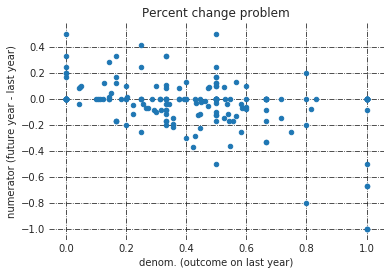

In [80]:
outcome = 'propSig_CentralVars'

group1outcome = df_output[outcome, group1].groupby(df_output.index).mean()
group2outcome = df_output[outcome, group2].groupby(df_output.index).mean()
    
perc_changes = 100*(group2outcome - group1outcome)/ group1outcome
print group1outcome.mean(), group2outcome.mean(),  perc_changes.mean()

dftemp = pd.concat([group1outcome, group2outcome, (group2outcome-group1outcome), perc_changes], axis=1)
dftemp.plot.scatter(x=(u'propSig_CentralVars', u'on last GSS year'), y=0)
plt.title('Percent change problem')
plt.xlabel('denom. (outcome on last year)')
plt.ylabel('numerator (future year - last year)')

0.11668297952511944 0.11034009692606624 4.229894350218508


Text(0,0.5,'numerator (future year - last year)')

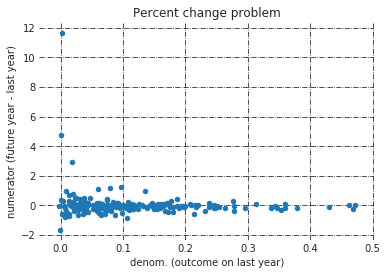

In [81]:
outcome = 'adjRs'

group1outcome = df_output[outcome, group1].groupby(df_output.index).mean()
group2outcome = df_output[outcome, group2].groupby(df_output.index).mean()
    
perc_changes = 100*(group2outcome - group1outcome)/ group1outcome
print group1outcome.mean(), group2outcome.mean(),  perc_changes.mean()

dftemp = pd.concat([group1outcome, group2outcome, (group2outcome-group1outcome), (group2outcome-group1outcome)/group1outcome], axis=1)
dftemp.plot.scatter(x=(outcome, u'on last GSS year'), y=1)
plt.title('Percent change problem')
plt.xlabel('denom. (outcome on last year)')
plt.ylabel('numerator (future year - last year)')

Text(0.5,0,'Change')

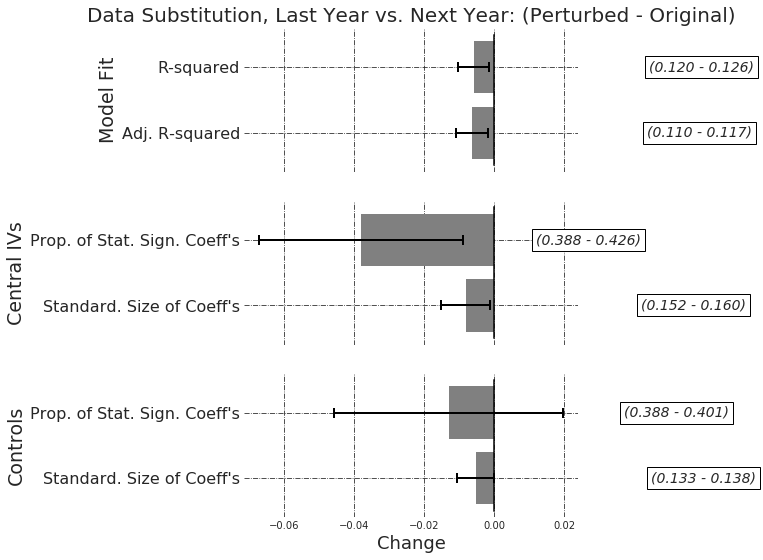

In [82]:
######################################################################################
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)
colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
#     xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    xerr = 2*conservativeSES[i*2:i*2+2]
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)

    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + .05 # the indices here mean get the x-coord of bottom-right box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + .05
    axarr[i].text(box0_xcoord, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)        
    
axarr[0].set_title('Data Substitution, Last Year vs. Next Year: (Perturbed - Original)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('Controls', fontsize=19)
axarr[2].set_xlabel('Change', fontsize=18)
# plt.xticks(fontsize=16)
# plt.xlim(-10, 50)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

# plt.savefig('images/last-vs-next--original-minus-perturbed.svg', bbox_inches='tight', dpi=150)

In [13]:
df_output.head()

outcome on last GSS year                                                 \
group            propSig paramSizesNormed        Rs     adjRs   pvalues   
0                    0.6         0.130022  0.032214  0.028940  0.303931   
1                    0.8         0.129544  0.060203  0.057024  0.156770   
2                    0.4         0.080410  0.008040  0.004684  0.349825   
3                    0.6         0.192286  0.135295  0.132370  0.290748   
4                    0.0         0.095582  0.002846 -0.000528  0.301788   

outcome                                                                       \
group   propSig_CentralVars paramSizesNormed_CentralVars pvalues_CentralVars   
0                       0.5                     0.251664            0.487490   
1                       0.5                     0.189065            0.379908   
2                       0.0                     0.094482            0.763988   
3                       0.5                     0.328620            0.481901   
4                       0.0                     0.184570            0.362165   

outcome on first "future" GSS year                                       \
group                      propSig paramSizesNormed        Rs     adjRs   
0                              0.2         0.202874  0.025772  0.022509   
1                              0.6         0.226900  0.078751  0.075666   
2                              0.0         0.160381  0.005100  0.001768   
3                              0.6         0.232311  0.132956  0.130052   
4                              0.0         0.164381  0.004643  0.001309   

outcome                                                             \
group     pvalues propSig_CentralVars paramSizesNormed_CentralVars   
0        0.136581                 0.5                     0.442520   
1        0.092240                 0.5                     0.419860   
2        0.225383                 0.0                     0.347282   
3        0.124524                 0.5                     0.408552   
4        0.399256                 0.0                     0.386811   

outcome                     article_id  
group   pvalues_CentralVars             
0                  0.101430       6642  
1                  0.047124       6642  
2                  0.175013       6642  
3                  0.283578       6642  
4                  0.080059       6642

In [75]:
from scipy.stats import ttest_1samp

df_output_copy = df_output.copy()
df_output_copy['difference'] = 100*(df_output[group2, outcome] - df_output[group1, outcome])

# mask = df_output_copy.loc[:,(slice(None), outcome)].notnull().all(axis=1)
mean_diff = df_output_copy.groupby('article_id').difference.mean()

ttest_1samp(mean_diff, 0)
se = mean_diff / np.std(mean_diff) / sqrt(len(mean_diff))



Ttest_1sampResult(statistic=-1.1651712150853109, pvalue=0.24539523819694023)

Perform t-tests
--

In [ ]:
# # (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_1samp
for outcome in outcomes:
    print outcome
    print 'mean group 1', df_output[group1, outcome].mean()
    print 'mean group 2', df_output[group2, outcome].mean()
    print ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1]
    print

Perform t-tests and Tests using *clustered errors*
--

1. Perform related-sample t-test (samples must be of equal lengths)

2. Perform independent samples t-test (just for kicks, to see how big our effects are)

3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html

Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Note
--
For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.

Outcome
--
The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?


In [ ]:
# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', np.around(df_output[group1, outcome].mean(), 3)
    print 'Mean after substitution:', np.around(df_output[group2, outcome].mean(), 3)
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                            cov_kwds=dict(groups=df_output.article_id))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'Clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

How many models' avg p-value is above 0.05?
--

In [ ]:
# # need to see tally up how switched from being below to being above
# # i.e. need to condition on being below beforehand, and how many of those are above now

# print 'count:', df_output[group2]['pvalues'][df_output[group2]['pvalues'] > 0.05].shape[0]
# print 'total:', df_output.shape[0]
# print 'percent:', df_output[]['pvalues'][df_output['cognate models']['pvalues'] > 0.05].shape[0]/ df_output.shape[0]